Setup the environment with the required libraries (opencv, mediapipe) 

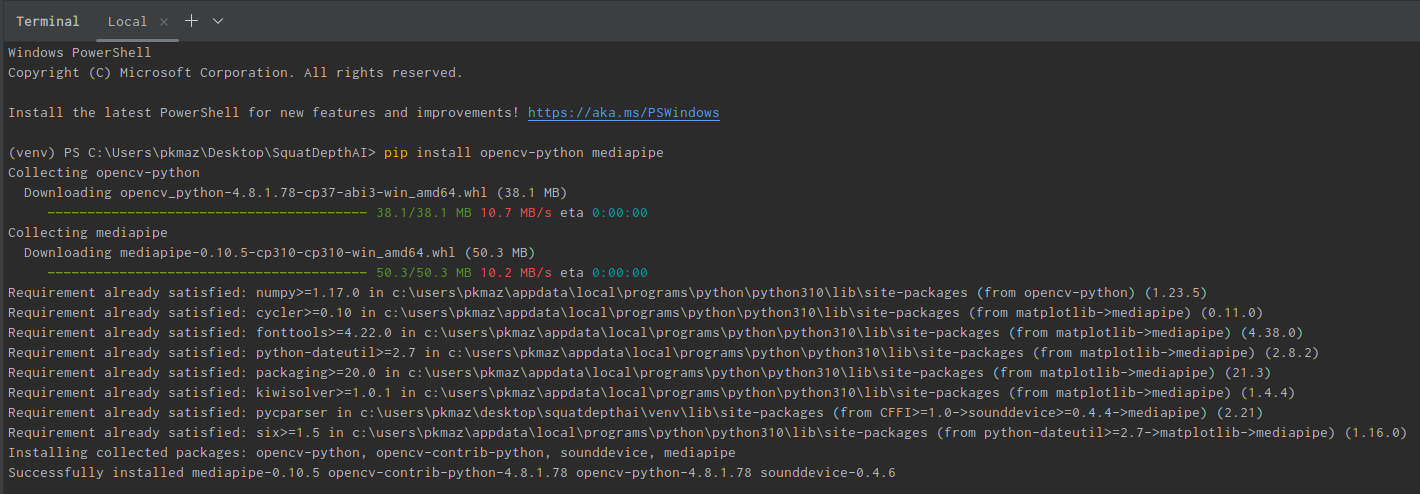

In [1]:
# display an image called 'installlibs.png' in the notebook 
from IPython.display import Image 
Image(filename='installlibs.png')

Pose Estimation using MediaPipe (Process each frame with MediaPipe to extract the pose landmarks) 

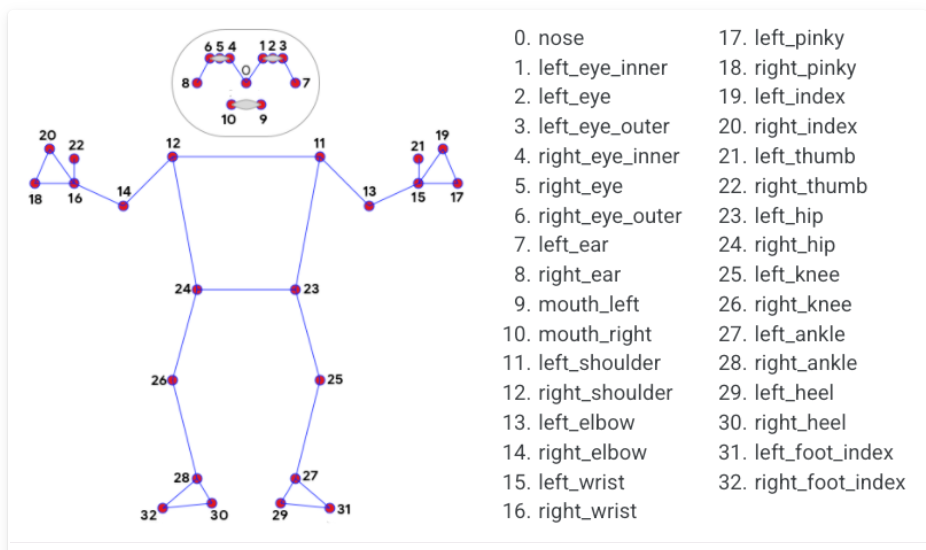

In [2]:
Image(filename='points.png')

In [25]:
import cv2
import mediapipe as mp
import numpy as np

mp_pose = mp.solutions.pose
pose = mp_pose.Pose()

colors = {
    "red": (0, 0, 255),
    "green": (0, 255, 0),
    "blue": (255, 0, 0),
    "white": (255, 255, 255)
}

def angle_calculation(a, b):
    a = np.array(a)
    b = np.array(b)
    angle = np.arctan2(b[1] - a[1], b[0] - a[0]) * 180.0 / np.pi
    return angle

def determine_squat_state(angle):
    if angle > 80:
        return "Top"
    elif angle > 45:
        return "Midway"
    elif angle > 20:
        return "Almost Depth"
    elif angle > 10:
        return "Depth"
    else:
        return "Below Parallel"

def process_video(video_path):
    cap = cv2.VideoCapture(video_path)
    valid_depth_reached = False
    squat_start = False
    squat_down = False
    reps_counted = 0
    bad_reps = 0
    good_reps = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(rgb_frame)

        if results.pose_landmarks:
            height, width, _ = frame.shape

            def draw_landmarks_get_angle(landmark_a, landmark_b, color):
                xa, ya = int(landmark_a.x * width), int(landmark_a.y * height)
                xb, yb = int(landmark_b.x * width), int(landmark_b.y * height)
                
                cv2.circle(frame, (xa, ya), 5, color, -1)
                cv2.circle(frame, (xb, yb), 5, color, -1)
                cv2.line(frame, (xa, ya), (xb, yb), color, 2)
                
                return angle_calculation((xa, ya), (xb, yb))

            angle_hip_left = draw_landmarks_get_angle(
                results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_HIP],
                results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_KNEE],
                colors['green']
            )

            angle_hip_right = draw_landmarks_get_angle(
                results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_HIP],
                results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_KNEE],
                colors['blue']
            )

            feedback_left = f"Left Hip Angle: {int(angle_hip_left)} ({determine_squat_state(angle_hip_left)})"
            feedback_right = f"Right Hip Angle: {int(angle_hip_right)} ({determine_squat_state(angle_hip_right)})"
            
            # Detect start of squat
            if angle_hip_left < 70 and angle_hip_right < 70:
                squat_start = True
            
            # Detect if user went to depth
            if squat_start and (angle_hip_left <= 10 and angle_hip_right <= 10):
                squat_down = True

            # Detect the transition from down to up
            if squat_start and (angle_hip_left >= 70 and angle_hip_right >= 70):
                reps_counted += 1
                if squat_down:
                    good_reps += 1
                    valid_depth_reached = True
                else:
                    bad_reps += 1
                    valid_depth_reached = False
                squat_down = False
                squat_start = False
            


            # Organizing and displaying the overlayed text
            cv2.putText(frame, feedback_left, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, colors['green'], 2, cv2.LINE_AA)
            cv2.putText(frame, feedback_right, (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.8, colors['blue'], 2, cv2.LINE_AA)
            
            cv2.putText(frame, f'Total reps: {reps_counted}', (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.8, colors['white'], 2, cv2.LINE_AA)
            cv2.putText(frame, f'Good reps: {good_reps}', (10, 120), cv2.FONT_HERSHEY_SIMPLEX, 0.8, colors['green'], 2, cv2.LINE_AA)
            cv2.putText(frame, f'Bad reps: {bad_reps}', (10, 150), cv2.FONT_HERSHEY_SIMPLEX, 0.8, colors['red'], 2, cv2.LINE_AA)

            cv2.imshow('MediaPipe Pose Estimation', frame)
            if cv2.waitKey(10) & 0xFF == ord('q'):
                break

    cap.release()
    cv2.destroyAllWindows()

    return valid_depth_reached, reps_counted, good_reps, bad_reps

In [26]:
video_files = ['squatvideos/100KG SQUAT NEW 1 REP MAX (225lb).mp4']
results = {}
for video in video_files:
    depth_reached, reps, good, bad = process_video(video)
    results[video] = {"Valid Depth": depth_reached, "Repetitions": reps, "Good Reps": good, "Bad Reps": bad}

print(results)

{'squatvideos/100KG SQUAT NEW 1 REP MAX (225lb).mp4': {'Valid Depth': True, 'Repetitions': 1, 'Good Reps': 1, 'Bad Reps': 0}}


In [27]:
video_files = ['squatvideos/700lbs Squat. No belt or sleeves..mp4']
results = {}
for video in video_files:
    depth_reached, reps, good, bad = process_video(video)
    results[video] = {"Valid Depth": depth_reached, "Repetitions": reps, "Good Reps": good, "Bad Reps": bad}

print(results)

{'squatvideos/700lbs Squat. No belt or sleeves..mp4': {'Valid Depth': True, 'Repetitions': 1, 'Good Reps': 1, 'Bad Reps': 0}}


In [30]:
video_files = ['squatvideos/WORLDS SHAKIEST 7 PLATE SQUAT 😳.mp4']
results = {}
for video in video_files:
    depth_reached, reps, good, bad = process_video(video)
    results[video] = {"Valid Depth": depth_reached, "Repetitions": reps, "Good Reps": good, "Bad Reps": bad}

print(results)

{'squatvideos/WORLDS SHAKIEST 7 PLATE SQUAT 😳.mp4': {'Valid Depth': True, 'Repetitions': 1, 'Good Reps': 1, 'Bad Reps': 0}}
